<a href="https://colab.research.google.com/github/Hodik/learning/blob/main/makemore_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-02-12 12:50:49--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-02-12 12:50:49 (8.03 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [8]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [9]:
len(words)

32033

In [10]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [19]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch
from dataclasses import dataclass

@dataclass
class Config:
    n_embd = 64
    n_embd2 = 64
    block_size = 8
    vocab_size = 27
    cell_type = 'lstm'

class GRUCell(nn.Module):
    """
    same job as RNN cell, but a bit more complicated recurrence formula
    that makes the GRU more expressive and easier to optimize.
    """
    def __init__(self, config):
        super().__init__()
        # input, forget, output, gate
        self.xh_to_z = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_r = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_hbar = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        # first use the reset gate to wipe some channels of the hidden state to zero
        xh = torch.cat([xt, hprev], dim=1)
        r = F.sigmoid(self.xh_to_r(xh))
        hprev_reset = r * hprev
        # calculate the candidate new hidden state hbar
        xhr = torch.cat([xt, hprev_reset], dim=1)
        hbar = F.tanh(self.xh_to_hbar(xhr))
        # calculate the switch gate that determines if each channel should be updated at all
        z = F.sigmoid(self.xh_to_z(xh))
        # blend the previous hidden state and the new candidate hidden state
        ht = (1 - z) * hprev + z * hbar
        return ht


class LSTMCell(nn.Module):
    """
    same job as RNN cell, but a bit more complicated recurrence formula
    that makes the GRU more expressive and easier to optimize.
    """
    def __init__(self, config):
        super().__init__()
        # input, forget, output, gate
        self.xh_to_f = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_g = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_i = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_d = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev, cprev):
        # first use the reset gate to wipe some channels of the hidden state to zero
        xh = torch.cat([xt, hprev], dim=1)
        f = F.sigmoid(self.xh_to_f(xh))
        ct = f * cprev

        # calculate the new cell state ct
        ct = ct + (F.sigmoid(self.xh_to_i(xh)) * F.tanh(self.xh_to_g(xh)))
        # calculate the new hidden state ht
        ht = (F.tanh(ct) * F.sigmoid(self.xh_to_d(xh)))
        return ht, ct

class RNN(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start_hidden = nn.Parameter(torch.zeros(1, config.n_embd2)) # the starting hidden state
        self.start_cell = nn.Parameter(torch.zeros(1, config.n_embd2)) # the starting hidden state
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # token embeddings table
        self.cell = LSTMCell(config) if config.cell_type == 'lstm' else GRUCell(config)
        self.cell2 = LSTMCell(config) if config.cell_type == 'lstm' else GRUCell(config)
        self.lm_head = nn.Linear(config.n_embd2 * 2, config.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()

        # embed all the integers up front and all at once for efficiency
        emb = self.wte(idx) # (b, t, n_embd)

        # sequentially iterate over the inputs and update the RNN state each tick
        hts = []
        ht1 = self.start_hidden.expand((b, -1)) # expand out the batch dimension
        if self.config.cell_type == 'lstm':
          ct1 = self.start_cell.expand((b, -1)) # expand out the batch dimension
        for i in range(t):
            xt = emb[:, i, :] # (b, n_embd)
            if self.config.cell_type == 'lstm':
              ht1, ct1 = self.cell(xt, ht1, ct1) # (b, n_embd2)
            else:
              ht1 = self.cell(xt, ht1)

            hts.append(ht1)


        ht2 = self.start_hidden.expand((b, -1)) # expand out the batch dimension
        if self.config.cell_type == 'lstm':
          ct2 = self.start_cell.expand((b, -1)) # expand out the batch dimension
        for i in range(t):
            xt = hts[i] # (b, n_embd)
            if self.config.cell_type == 'lstm':
              ht2, ct2 = self.cell2(xt, ht2, ct2) # (b, n_embd2)
            else:
              ht2 = self.cell2(xt, ht2)

        logits = self.lm_head(torch.cat((ht1, ht2), dim=1))

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)

        return logits, loss



class RNNATT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start_hidden = nn.Parameter(torch.zeros(1, config.n_embd2)) # the starting hidden state
        self.start_cell = nn.Parameter(torch.zeros(1, config.n_embd2)) # the starting hidden state
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # token embeddings table
        self.cell = LSTMCell(config)
        self.lm_head = nn.Linear(config.n_embd2, config.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()

        # embed all the integers up front and all at once for efficiency
        emb = self.wte(idx) # (b, t, n_embd)

        # sequentially iterate over the inputs and update the RNN state each tick
        ht = self.start_hidden.expand((b, -1)) # expand out the batch dimension
        ct = self.start_cell.expand((b, -1)) # expand out the batch dimension
        hts = []
        for i in range(t):
            xt = emb[:, i, :] # (b, n_embd)
            ht, ct = self.cell(xt, ht, ct) # (b, n_embd2)
            hts.append(ht)

        logits = self.lm_head(ht, dim=1)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)

        return logits, loss


In [20]:
# build the dataset

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * Config.block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [23]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

model = RNN(Config())
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  logits, loss = model(Xb, Yb)

  model.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  if not i % 10000:
    print(loss.item())

  lossi.append(loss.item())

3.291872262954712
1.8594310283660889
1.8280142545700073
2.449490785598755
1.7414517402648926
1.553497314453125
2.1771275997161865
1.8643358945846558
1.8086349964141846
2.0001676082611084
2.1618614196777344
1.7960602045059204
1.8796569108963013
2.1293411254882812
2.0096490383148193
1.966475009918213
1.6782886981964111
1.4652824401855469
1.7277944087982178
1.5528820753097534


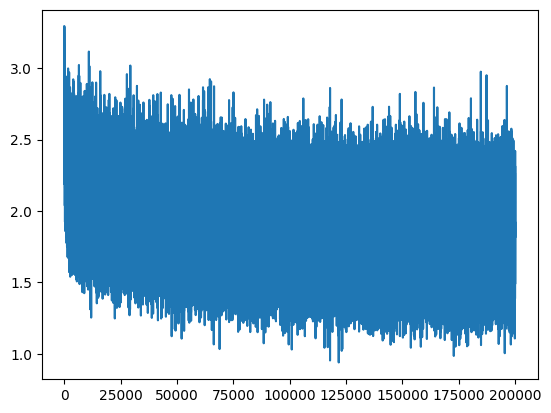

In [24]:
plt.plot(lossi)

In [25]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits, loss = model(x, y)
  print(split, loss)

model.eval()
split_loss('train')
split_loss('val')
model.train()

train tensor(1.7927)
val tensor(2.0056)


RNN(
  (wte): Embedding(27, 64)
  (cell): LSTMCell(
    (xh_to_f): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_g): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_i): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_d): Linear(in_features=128, out_features=64, bias=True)
  )
  (cell2): LSTMCell(
    (xh_to_f): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_g): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_i): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_d): Linear(in_features=128, out_features=64, bias=True)
  )
  (lm_head): Linear(in_features=128, out_features=27, bias=True)
)

In [26]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

model.eval()
for _ in range(20):

    out = []
    context = [0] * Config.block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits, _ = model(torch.tensor([context])) # (1,block_size,n_embd)
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

model.train()

mohammmya.
zieen.
nihayah.
remma.
jendra.
graden.
deelin.
shyloe.
leighstan.
aaryah.
zimroth.
cayshawn.
giagan.
jaki.
jewelynn.
novalyn.
brennder.
yarun.
elsy.
majadou.


RNN(
  (wte): Embedding(27, 64)
  (cell): LSTMCell(
    (xh_to_f): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_g): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_i): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_d): Linear(in_features=128, out_features=64, bias=True)
  )
  (cell2): LSTMCell(
    (xh_to_f): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_g): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_i): Linear(in_features=128, out_features=64, bias=True)
    (xh_to_d): Linear(in_features=128, out_features=64, bias=True)
  )
  (lm_head): Linear(in_features=128, out_features=27, bias=True)
)

LSTM 2 layers:
train tensor(1.7927)
val tensor(2.0056)


LSTM with attention:
